In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op
az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.float_format',  '{:}'.format)

In [2]:
df = pd.read_csv("sao-158379.csv", sep=',')
df.head()

,FrameNum,timeInfo,signal-target
0,2801.0,[12:56:56.9572],417856.0
1,2802.0,[12:56:56.9773],331218.0
2,2803.0,[12:56:56.9973],382878.0
3,2804.0,[12:56:57.0174],383219.0
4,2805.0,[12:56:57.0374],373990.0


In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

,FrameNum,timeInfo,signal-target
0,2801.0,2022-08-01 12:56:56.957200,417856.0
1,2802.0,2022-08-01 12:56:56.977300,331218.0
2,2803.0,2022-08-01 12:56:56.997300,382878.0
3,2804.0,2022-08-01 12:56:57.017400,383219.0
4,2805.0,2022-08-01 12:56:57.037400,373990.0


In [4]:
data = df[['FrameNum','timeInfo','signal-target']]
data.columns = ['Frame','Time', 'Value']
data.head()

,Frame,Time,Value
0,2801.0,2022-08-01 12:56:56.957200,417856.0
1,2802.0,2022-08-01 12:56:56.977300,331218.0
2,2803.0,2022-08-01 12:56:56.997300,382878.0
3,2804.0,2022-08-01 12:56:57.017400,383219.0
4,2805.0,2022-08-01 12:56:57.037400,373990.0


In [5]:
data['JD'] = Time(data['Time']).jd

data['frac_JD'] = data['JD'] - np.floor(data['JD']).astype(int)
data

,Frame,Time,Value,JD,frac_JD
0,2801.0,2022-08-01 12:56:56.957200,417856.0,2459793.039548116,0.03954811580479145
1,2802.0,2022-08-01 12:56:56.977300,331218.0,2459793.039548348,0.03954834816977382
2,2803.0,2022-08-01 12:56:56.997300,382878.0,2459793.03954858,0.039548580069094896
3,2804.0,2022-08-01 12:56:57.017400,383219.0,2459793.0395488124,0.03954881243407726
4,2805.0,2022-08-01 12:56:57.037400,373990.0,2459793.039549044,0.039549043867737055
...,...,...,...,...,...
1195,3996.0,2022-08-01 12:57:20.903500,15561.0,2459793.039825272,0.03982527181506157
1196,3997.0,2022-08-01 12:57:20.923500,-191.0,2459793.0398255032,0.03982550324872136
1197,3998.0,2022-08-01 12:57:20.943600,-2107.0,2459793.039825736,0.039825736079365015
1198,3999.0,2022-08-01 12:57:20.963600,5244.0,2459793.0398259675,0.03982596751302481


Text(0.5, 0, 'Frames')

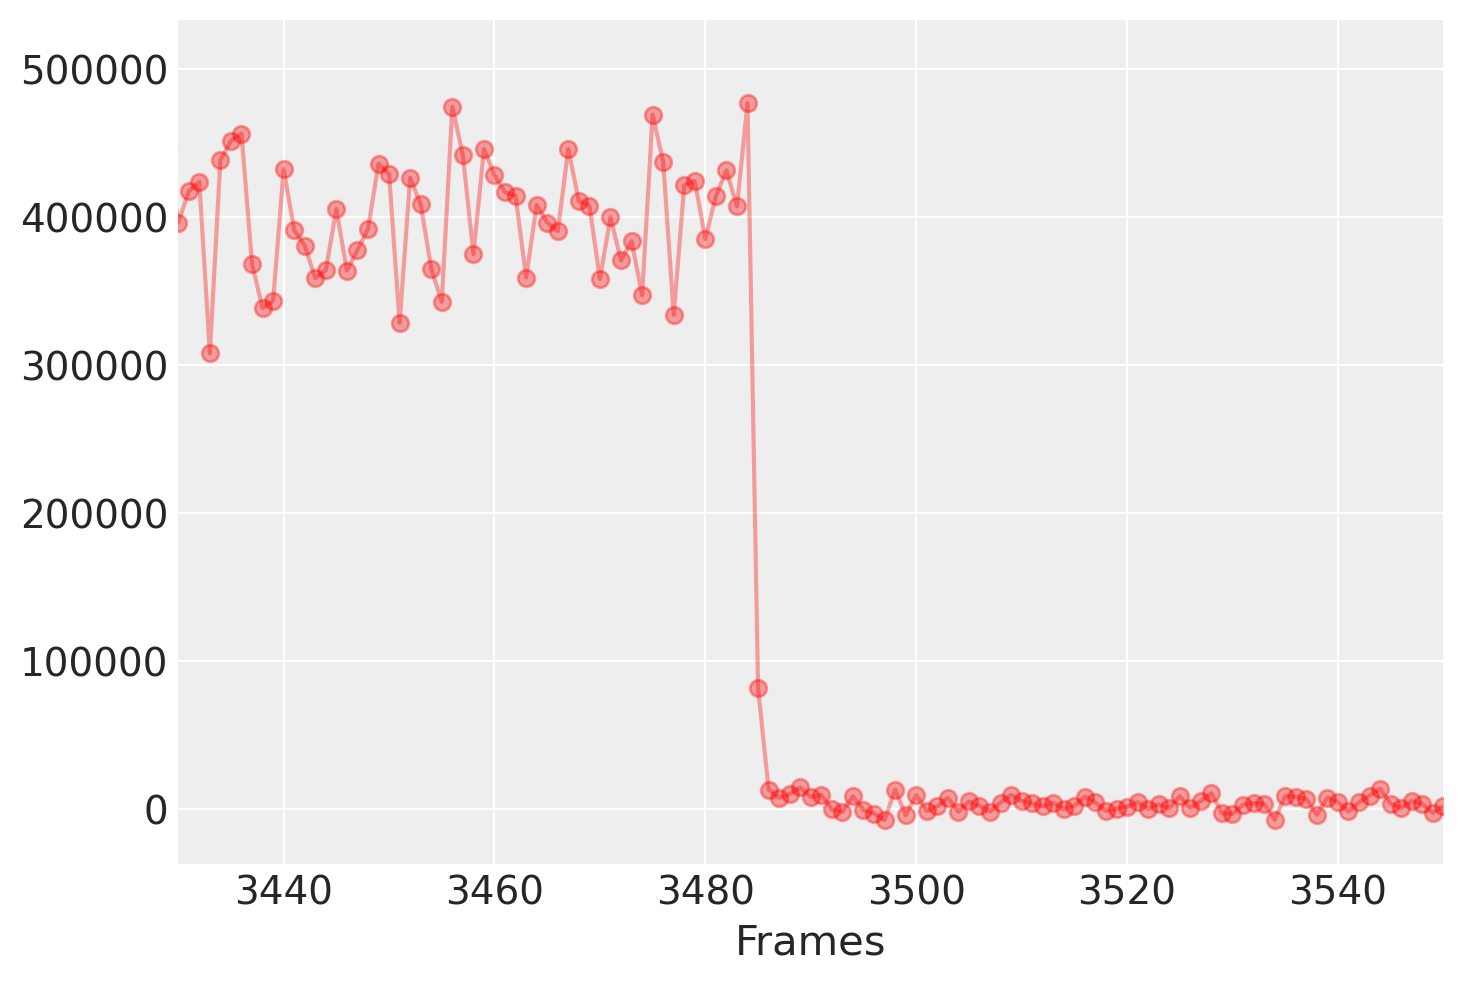

In [6]:
ig, ax = plt.subplots()
# ax.plot(data['Time'], data['Value'], 'ro', alpha=0.5)
ax.plot(data['Frame'], data['Value'], 'r-o', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(3430, 3550)
ax.set_xlabel('Frames')
# ax.set_aspect(1)
# plt.tight_layout()
# fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['frac_JD'], data['Value'], 'ro', alpha=0.5)
# ax.set_xlabel('Frac JD')

Text(0.5, 0, 'Frames')

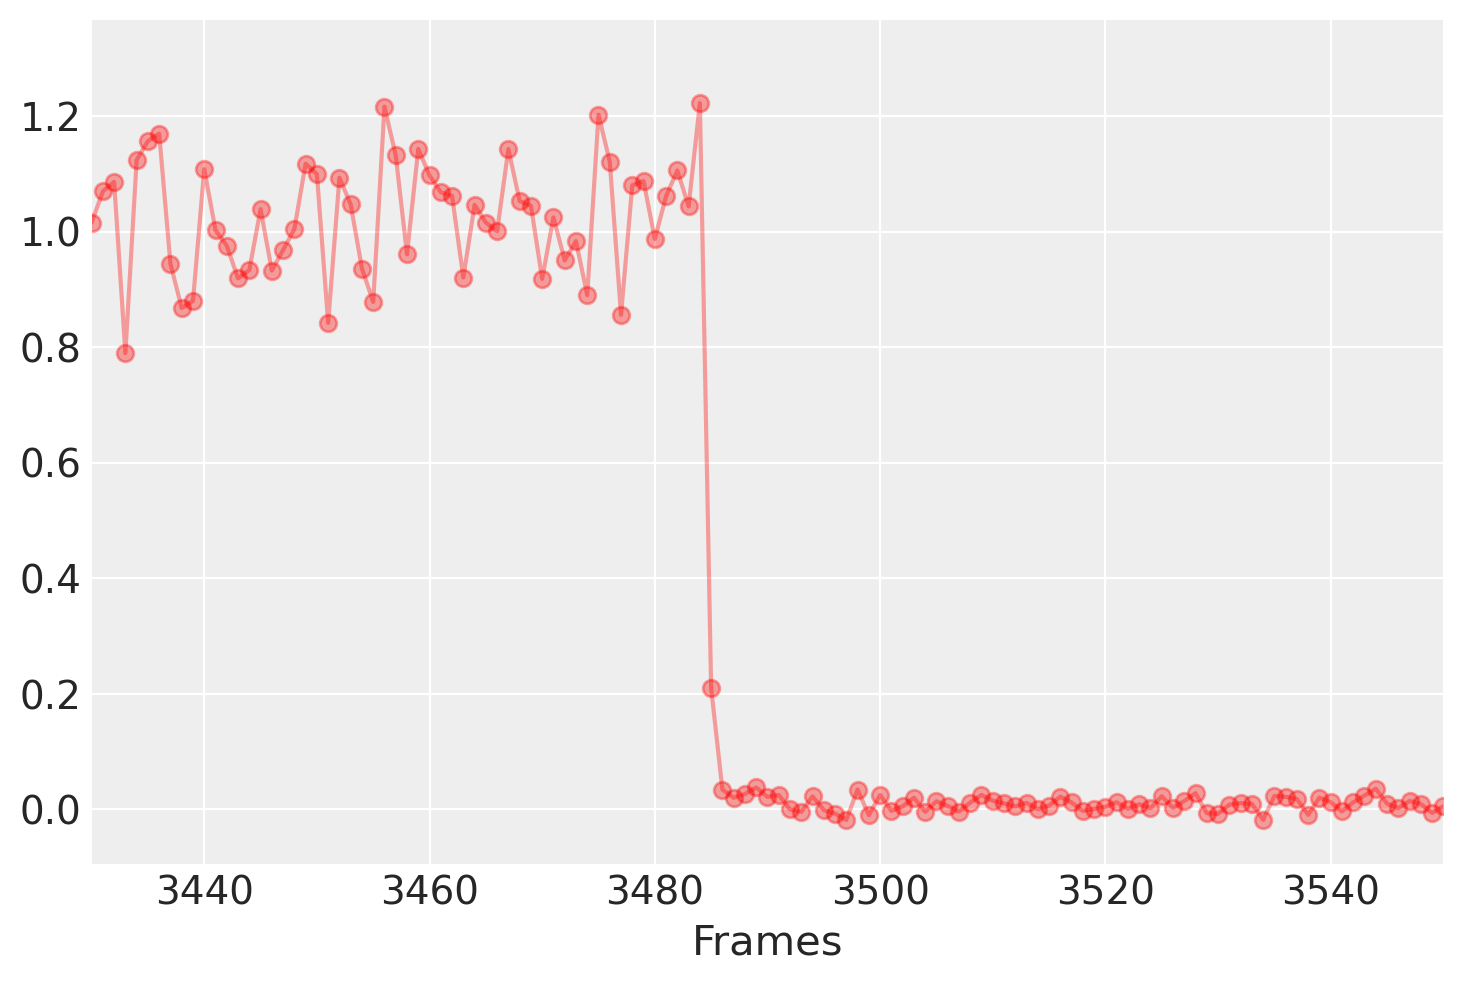

In [7]:
value_scaled = data['Value']/(data['Value'].std()*2)

fig, ax = plt.subplots()
# ax.plot(data['frac_JD'], value_scaled, 'ro', alpha=0.35)
ax.plot(data['Frame'], value_scaled, 'r-o', alpha=0.35)
ax.set_xlim(3430, 3550)
ax.set_xlabel('Frames')

In [8]:
def diffract(t, t0, v):
    cc, ss = sc.fresnel(-(v*(t-t0)))
    y = 0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

@as_op(itypes=[at.dvector, at.dscalar, at.dscalar],
       otypes=[at.dvector])
def a_diffract(t, t0, v):
    cc, ss = sc.fresnel(-(v*(t-t0)))
    y = 0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

In [9]:
x_data = np.linspace(2800, 4000, 1200)
σ_true = 0.1
t0_true = 3485
v_true = 1

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

y_data = diffract(x_data, t0_true, v_true)
y_data = rng.normal(y_data, scale=σ_true)

y_data_scaled = y_data / (y_data.std()*2)

# A_true_scaled = A_true / (y_data.std()*2)
# σ_true_scaled = σ_true / (y_data.std()*2)

(3430.0, 3550.0)

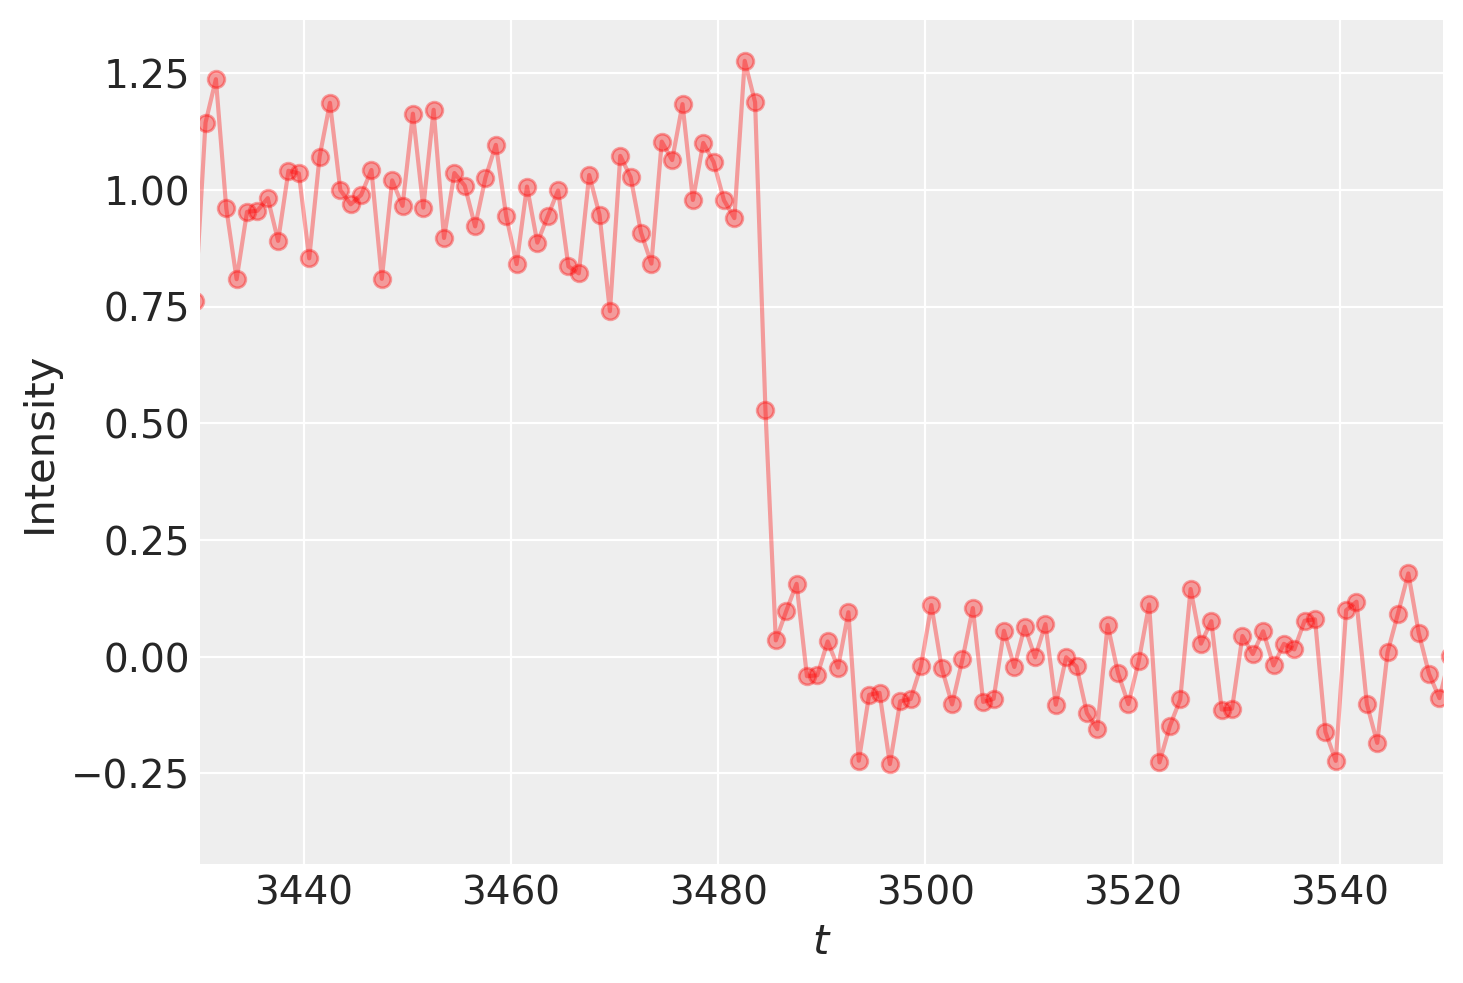

In [10]:
# plt.figure(figsize = (12,5), facecolor='w')
plt.plot(x_data, y_data_scaled, 'r-o', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.xlim(3430, 3550)

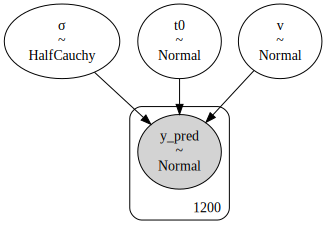

In [59]:
t = aesara.shared(x_data)
t0 = at.dscalar('t0')
v = at.dscalar('v')

with pm.Model() as model_fresnel:
    # t0 = pm.StudentT('t0', mu=3480, sigma=5, nu=5)
    # v = pm.StudentT('v', mu=1, sigma=5, nu=5)
    
    t0 = pm.Normal('t0', mu=3480, sigma=1)
    v = pm.Normal('v', mu=1, sigma=1)
    σ = pm.HalfCauchy('σ', beta=1.)
    mu = a_diffract(t, t0, v) # model-nya (expected value)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=σ, observed=y_data_scaled) # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [60]:
with model_fresnel:
    prior = pm.sample_prior_predictive()

In [61]:
with model_fresnel:
    idata = pm.sample(2500, tune=1000, cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [t0]
>>Slice: [v]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 2_500 draw iterations (2_000 + 5_000 draws total) took 25 seconds.


In [62]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,3485.066,0.188,3484.749,3485.366,0.024,0.017,62.0,181.0,1.06
v,0.582,0.062,0.439,0.667,0.01,0.007,49.0,41.0,1.1
σ,0.098,0.002,0.094,0.102,0.0,0.0,2107.0,3450.0,1.0


In [63]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

(3450.0, 3520.0)

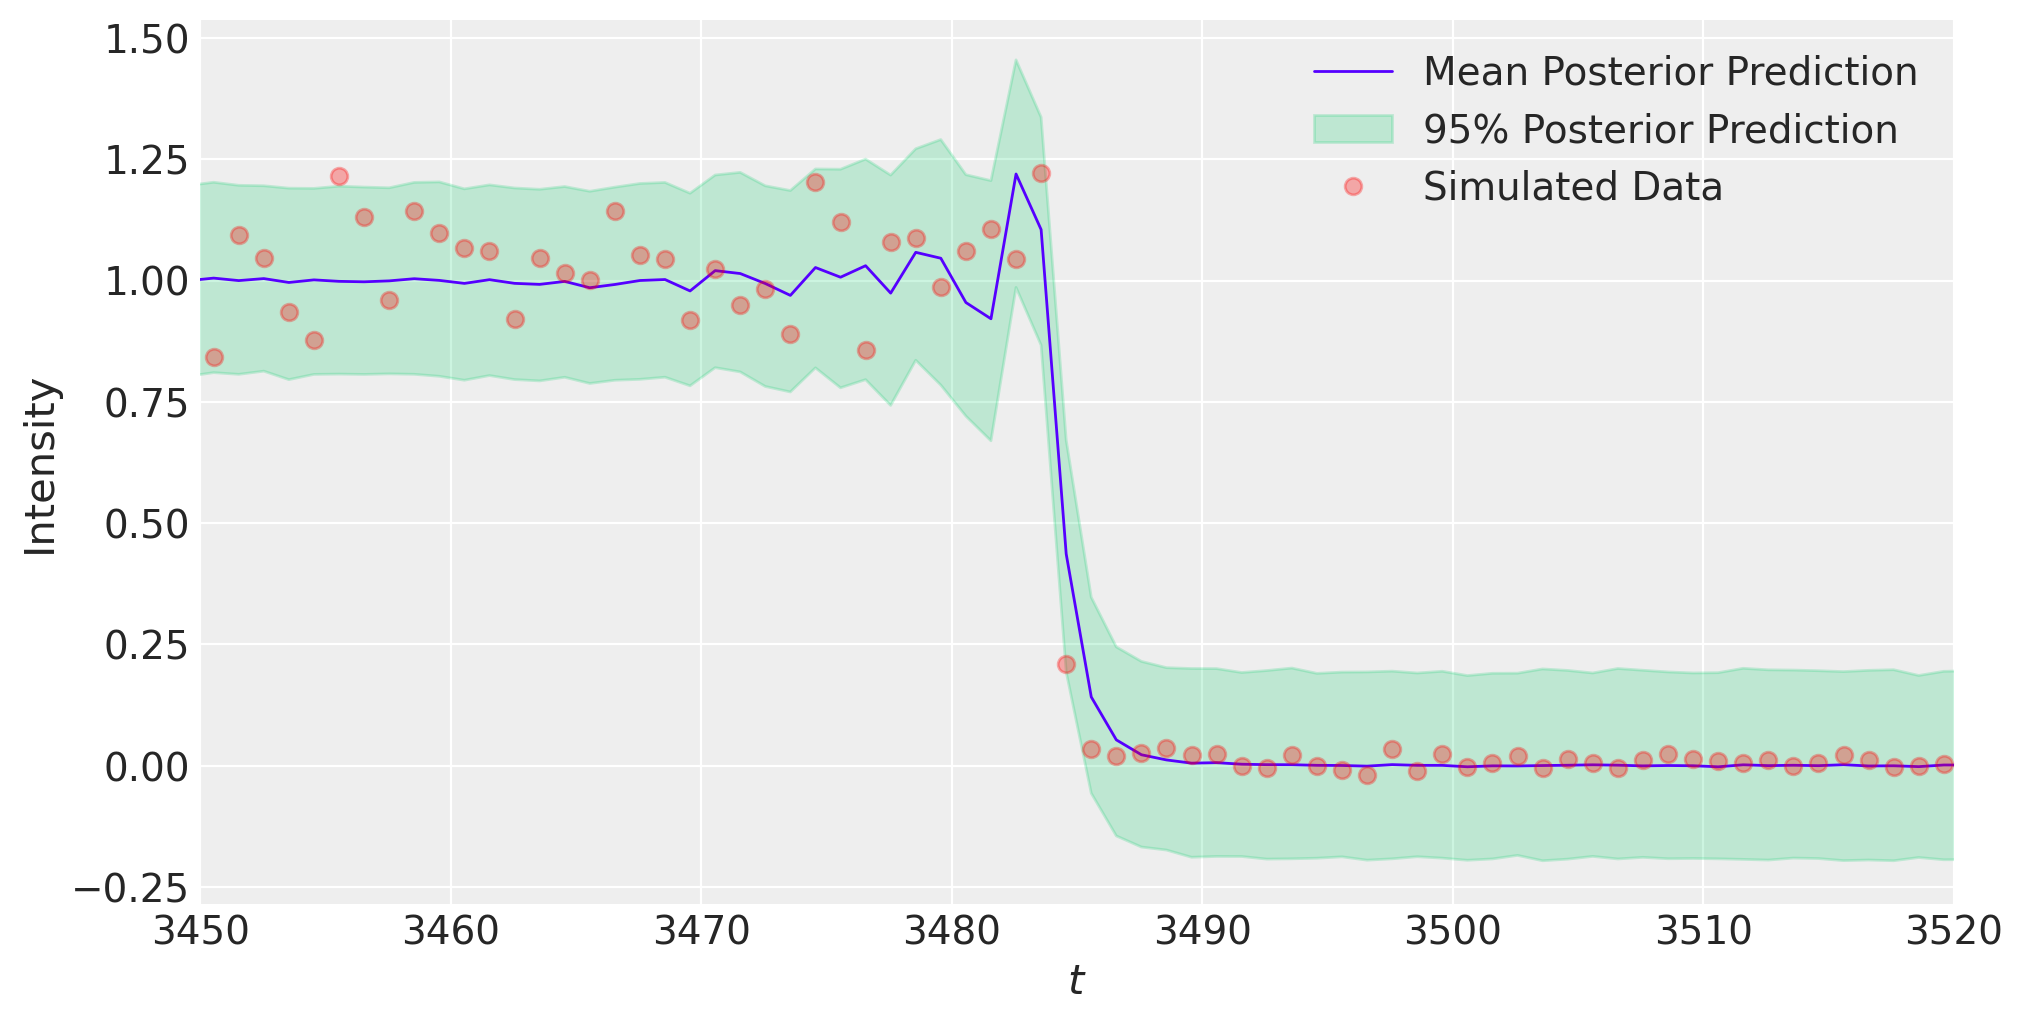

In [64]:
plt.figure(figsize=(10,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
# plt.scatter(x_data, y_data_scaled, c='r', marker='o', alpha=0.35)
plt.plot(x_data, value_scaled, 'ro', alpha=0.3)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])
plt.xlim(3450, 3520)

c:\Users\User\.conda\envs\work2\lib\site-packages\corner\core.py:103: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


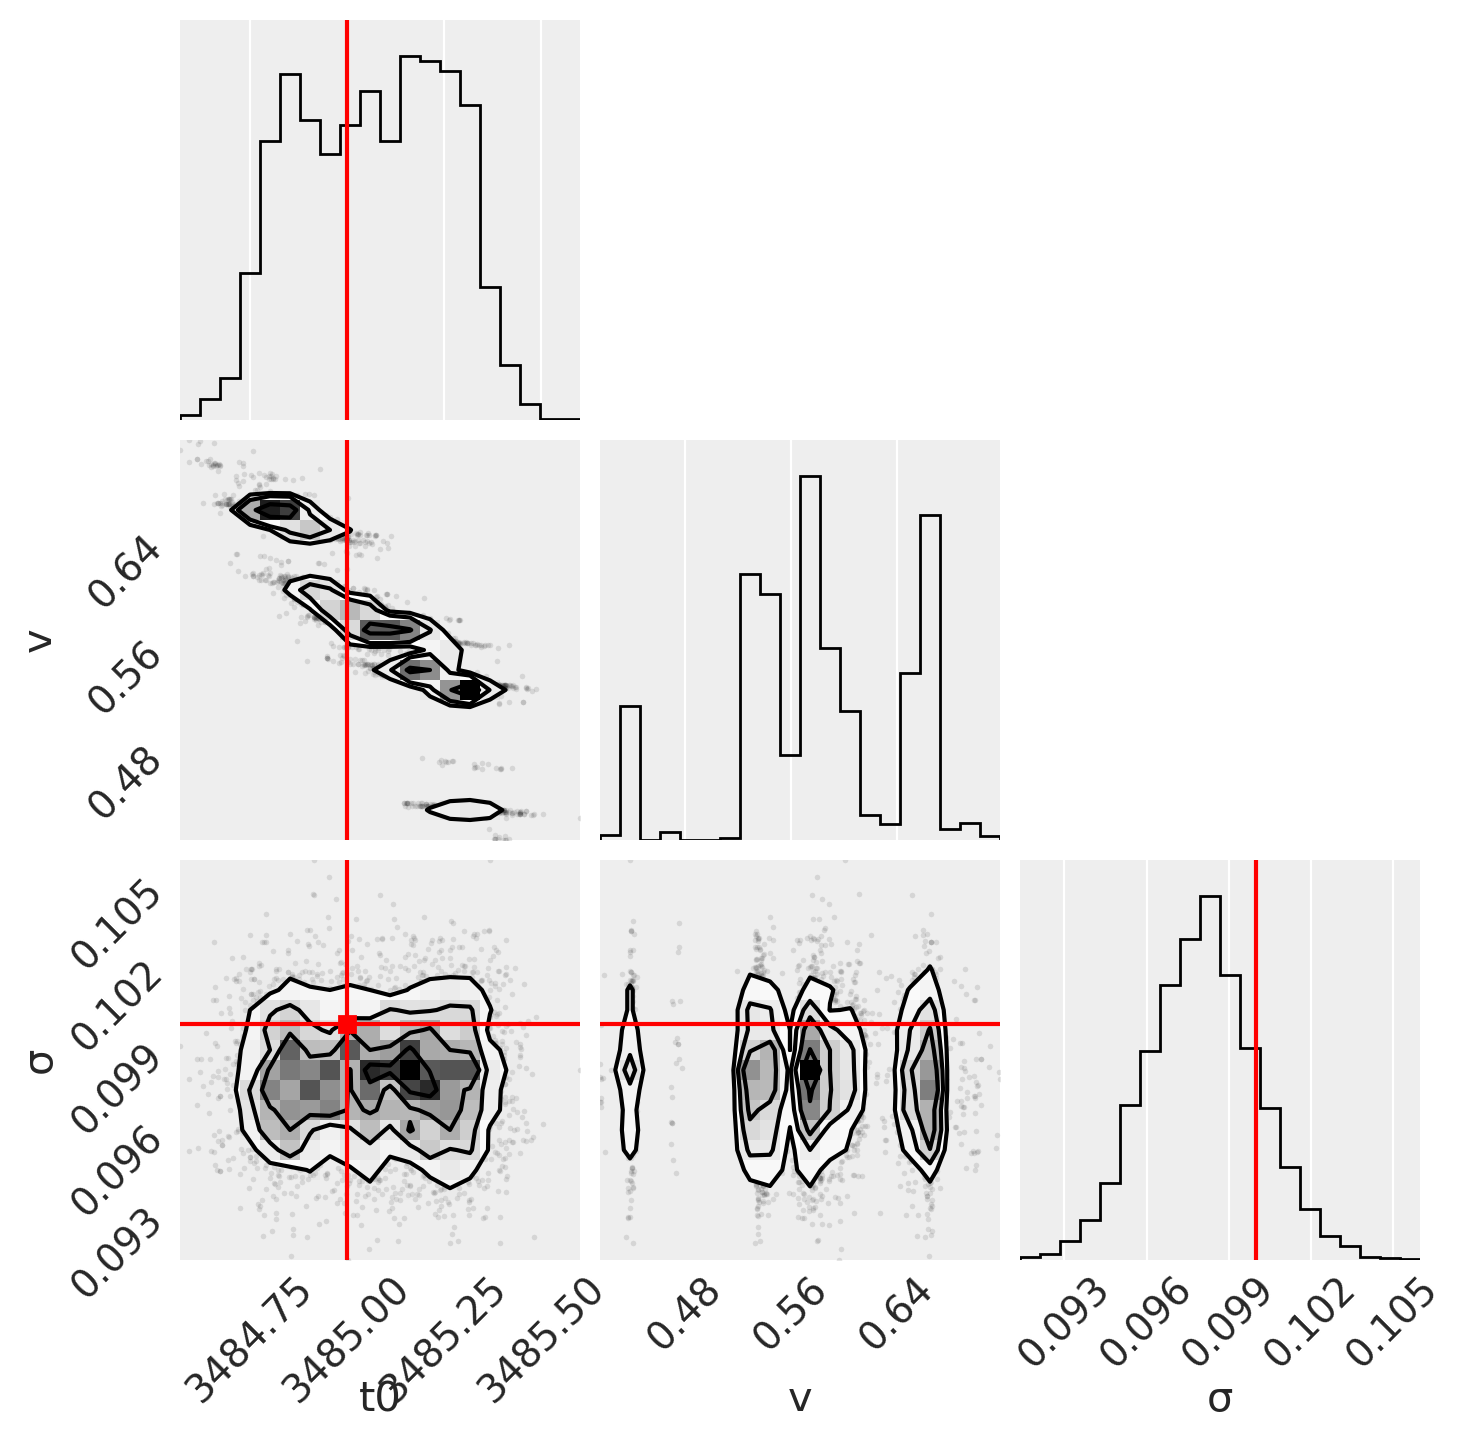

In [65]:
import corner

figure = corner.corner(idata, truths=[t0_true, v_true, σ_true], truth_color='red', divergences=True)

<AxesSubplot:xlabel='y_pred / y_pred'>

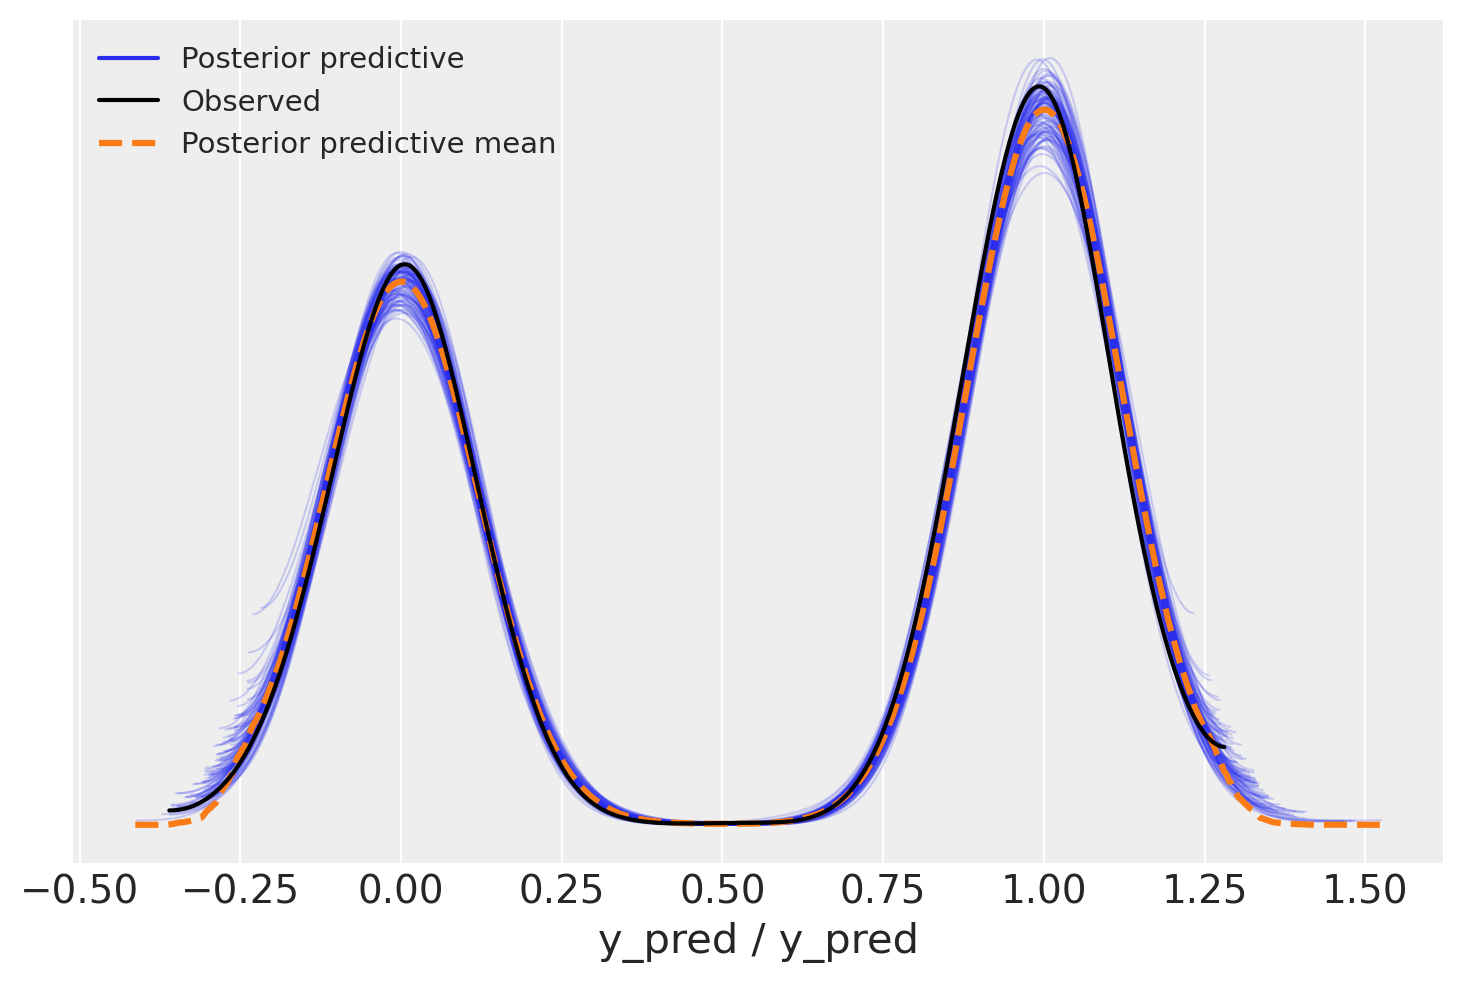

In [66]:
az.plot_ppc(idata, num_pp_samples=100)

Text(0, 0.5, 'Julian Date')

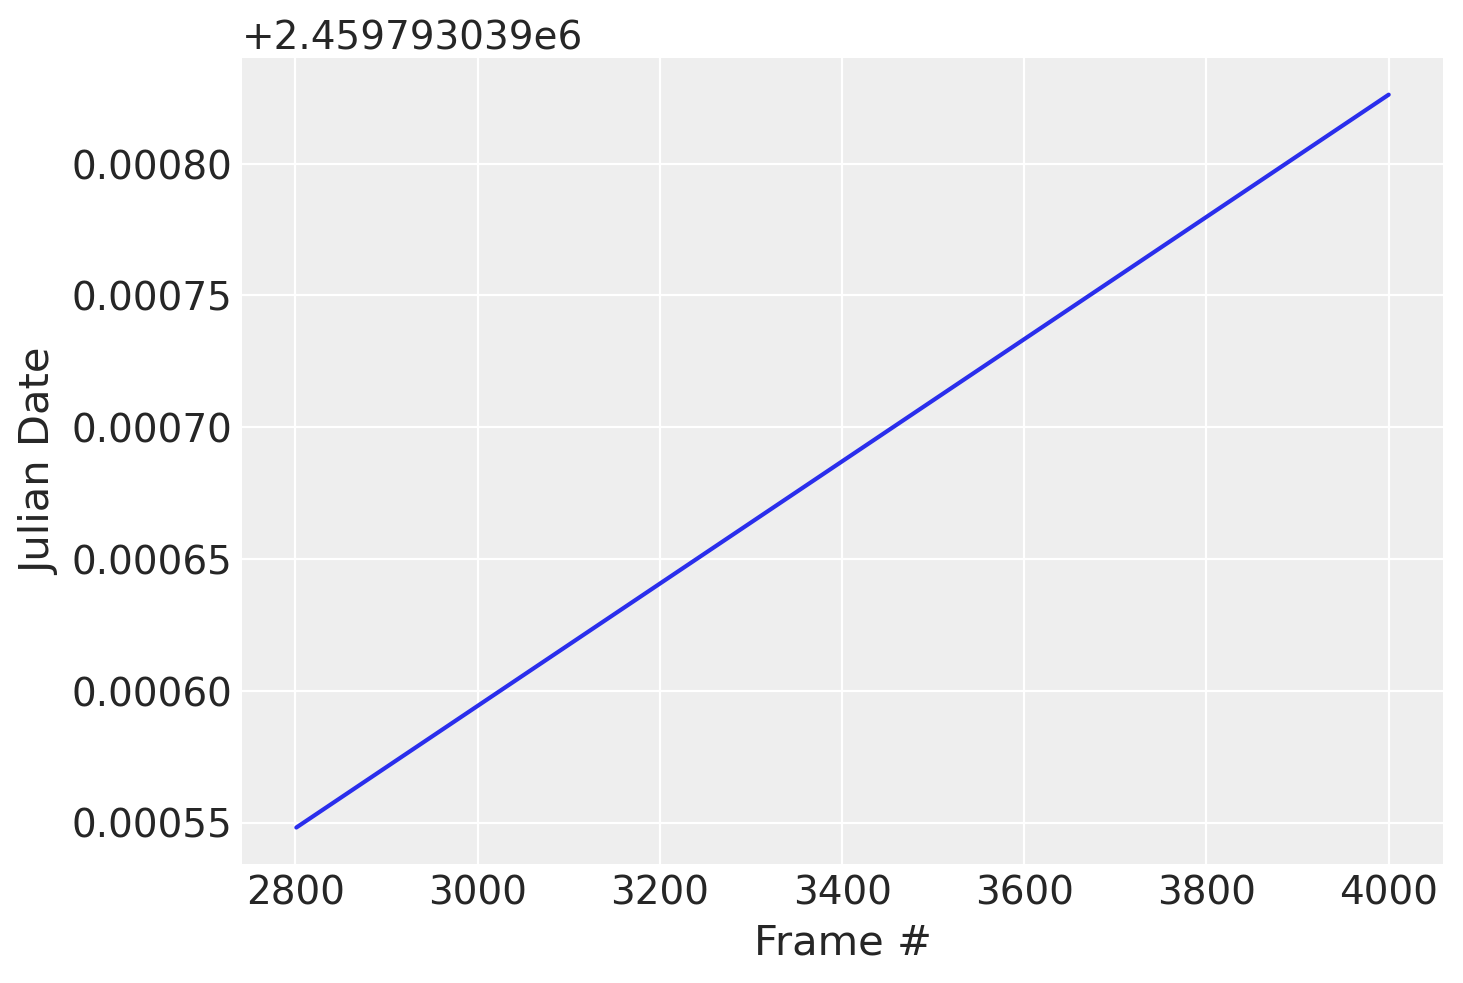

In [67]:
x = data['Frame']
y = data['JD']

f = interp1d(x, y, kind='cubic')

plt.plot(x, y)
plt.xlabel('Frame #')
plt.ylabel('Julian Date')

In [68]:
framenum = idata.posterior.mean().t0.values

# interpolasi

date = f(framenum)
type(date)

numpy.ndarray

In [69]:
date_str = np.array_str(date)
date_str

'2459793.0397067713'

In [70]:
# Ubah ke format waktu

j_date = Time(date_str, format='jd')
# j_date.value
iso_time = j_date.iso
iso_time

'2022-08-01 12:57:10.665'

In [71]:
t_iso_time = pd.to_datetime(iso_time)
t_iso_time.time()

datetime.time(12, 57, 10, 665000)

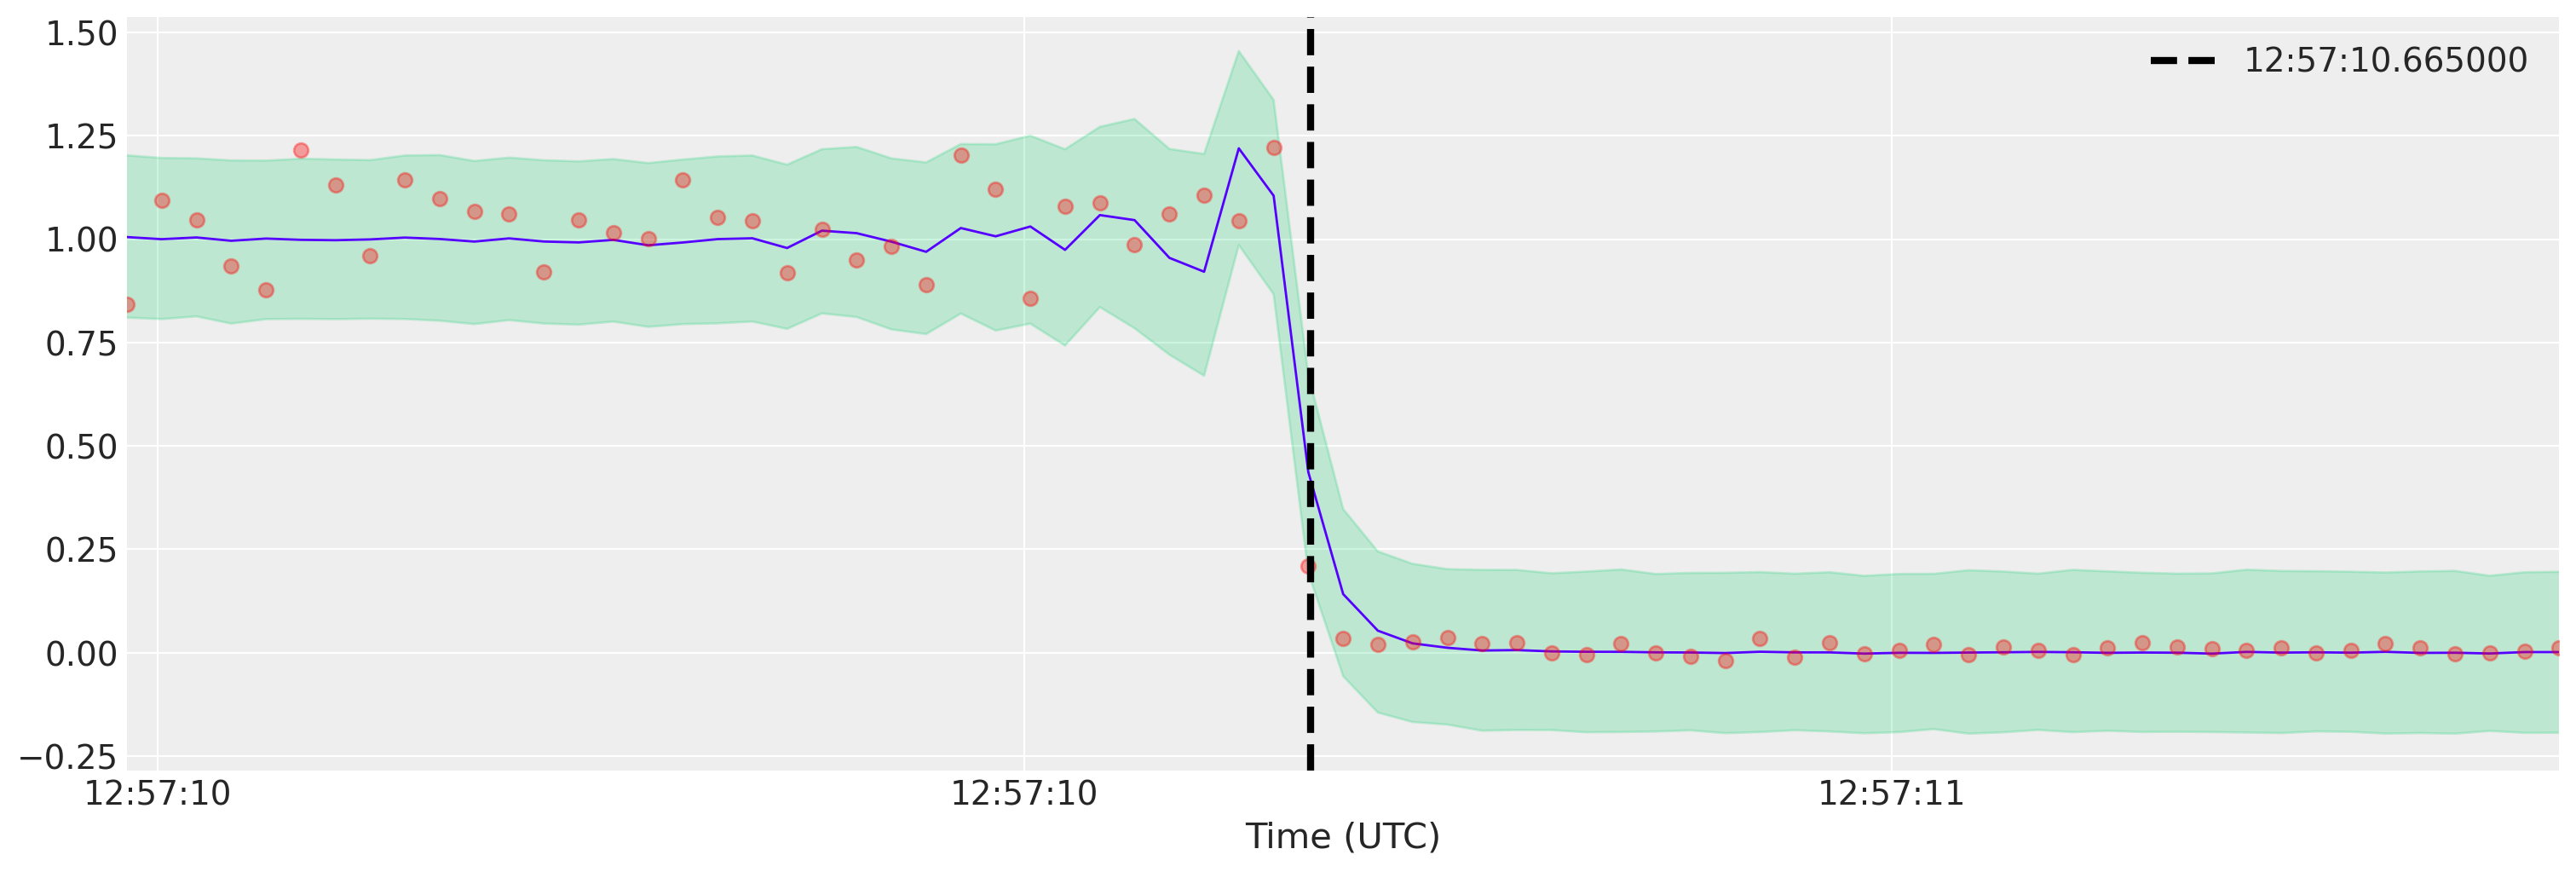

In [72]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data['Time'], mean_spp, linestyle='-', linewidth=1, color="#5500ff")
ax.fill_between(data['Time'], crit_l, crit_u, alpha=0.2, color="#00cc66")
ax.plot(data['Time'], value_scaled, 'ro', alpha=0.35)
# ax.plot(data['Time'], y_filtered, 'ro', alpha=0.35)

plt.axvline(x = t_iso_time, color = 'k', lw=3, ls='--', label = t_iso_time.time())
plt.legend(loc = 'upper right')

#ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(data['Time'][650], data['Time'][720]) # baris ke-# untuk kolom 'Time'
ax.set_xlabel('Time (UTC)')

date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
#ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
ax.xaxis.set_major_formatter(date_form)
# ax.tick_params('x', labelrotation=45)

# data['Time'].dt.hour()

In [85]:
# def standardize(series):
#     """Standardize a pandas series"""
#     return (series - series.mean()) / series.std()

In [86]:
import xarray as xr

x =  xr.DataArray(np.linspace(2800, 4000, 500), dims=["plot_dims"])

# x_scaled = standardize(x)

prior_data = prior.prior

y = diffract(x, prior_data["t0"], prior_data["v"])
# y_scaled = standardize(y)

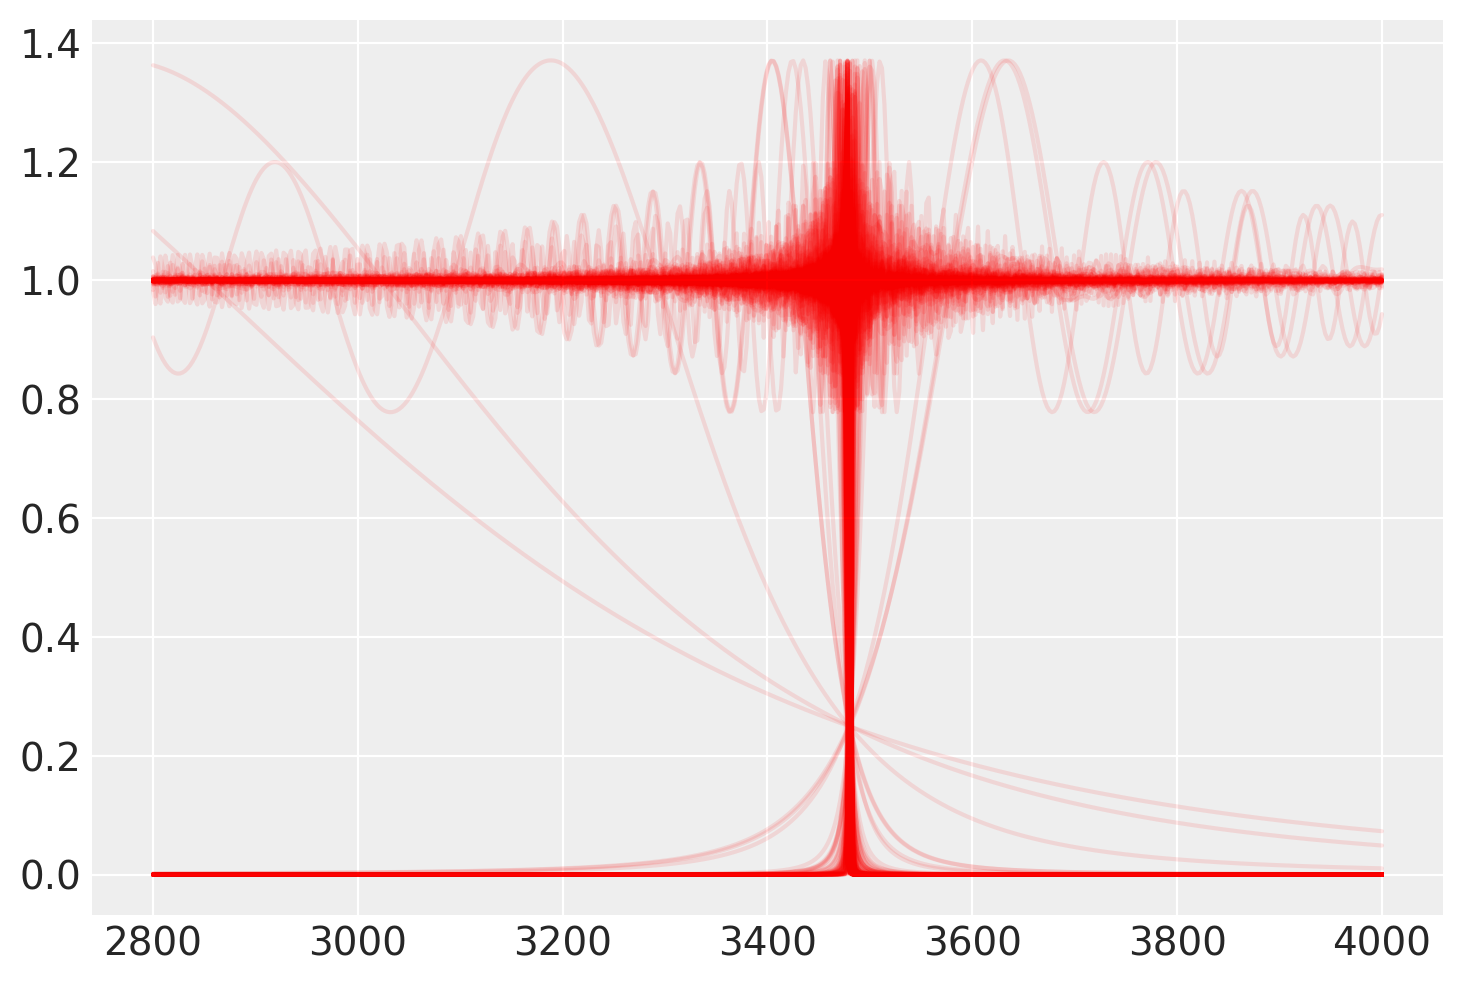

In [87]:
from random import sample


_, ax = plt.subplots()

ax.plot(x, y.stack(sample=("chain", "draw")), 'r-', alpha=0.1)

In [1]:
from sora import Star
from sora.star import kervella, van_belle

SORA version: 0.2.1


In [2]:
star = Star(coord='10 46 19.3154110752 +12 44 52.229807232')


1 Gaia-EDR3 star found G=6.888296
star coordinate at J2016.0: RA=10h46m19.31354s +/- 0.0312 mas, DEC=12d44m51.7095s +/- 0.0266 mas



In [3]:
print(star)

Gaia-EDR3 star Source ID: 3872479579365669888
ICRS star coordinate at J2016.0:
RA=10h46m19.31354s +/- 0.0312 mas, DEC=12d44m51.7095s +/- 0.0266 mas
pmRA=-1.698 +/- 0.042 mas/yr, pmDEC=-32.558 +/- 0.036 mas/yr
Gaia-EDR3 Proper motion corrected as suggested by Cantat-Gaudin & Brandt (2021) 
Plx=6.9556 +/- 0.0331 mas, Rad. Vel.=0.00 +/- 0.00 km/s 

Magnitudes: G:  6.888, B:  7.014, V:  6.913, R:  6.850, J:  6.615, H:  6.570,
            K:  6.543

Apparent diameter from Kervella et. al (2004):
    V: 0.1723 mas, B: 0.1708 mas
Apparent diameter from van Belle (1999):
    sg: B: 0.2233 mas, V: 0.2338 mas
    ms: B: 0.1713 mas, V: 0.1641 mas
    vs: B: 0.3440 mas, V: 0.3069 mas
